# Benchmark

Change directory to code.

In [1]:
import os
import numpy as np
import logging
import tensorflow as tf
import importlib.util
import sys

# Important directories
code_dir = os.path.dirname(os.getcwd())
deep_cal_dir = os.path.dirname(os.path.dirname(os.getcwd()))

# Allows to import modules below
sys.path.insert(0, code_dir)

from ann.helpers import load_labeled_csv
from ann.neural_network import dense_nn
from predict import predict

In [2]:
# Logging stuff
logger = logging.getLogger("benchmarking")
logger.setLevel(logging.INFO)
fh = logging.FileHandler(deep_cal_dir + "/code/logs/benchmarking.log")    
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

## Benchmark preparations

In [3]:
# Labeled data configuration
train_filename = deep_cal_dir + '/data/heston/training_data.csv'
test_filename = deep_cal_dir + '/data/heston/testing_data.csv'
feature_cols = [ _ for _ in range(7)]
label_cols = [7]

# Configuration of neural network
layer_sizes = [32,2,64]

# Directory to stored checkpoint files of NN
ckpt_dir = deep_cal_dir + '/results/' + 'nn=32,2,64_lr=4.210271E-03_mbs=1024,pkeep=1.0000'

Preprocessing input data.

In [4]:
# Read training and validation data named tuples into memory.
logger.info("Importing and normalizing input labeled data.")

train_tuple = load_labeled_csv(train_filename, feature_cols, label_cols)
test_tuple = load_labeled_csv(test_filename, feature_cols, label_cols)

# Normalize test data by training statistics
train_mean = np.mean(train_tuple.features, axis=0)
train_std = np.std(train_tuple.features, axis=0)

test_tuple.features -= train_mean
test_tuple.features /= train_std

logger.info('Finished import and normalization of input data.')

Building the neural network approximating the implied volatility function.

In [5]:
logger.info("Building computational graph of a fully connected neural network.")
nn = dense_nn(test_tuple.nb_features, layer_sizes, test_tuple.nb_labels)
logger.info('Building completed.')

Initiating interactive tensorflow session and loading training results.

In [6]:
logger.info('Starting interactive tensorflow session.')
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint(ckpt_dir))
logger.info('Checkpoint loaded.')

INFO:tensorflow:Restoring parameters from /Users/stemper/Dropbox/Promotion/projects/deep_calibration/results/nn=32,2,64_lr=4.210271E-03_mbs=1024,pkeep=1.0000/final_model


### Timing

In [7]:
%timeit test_results = predict(test_tuple.features, nn, sess)

34.8 ms ± 2.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Accuracy

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

def set_style():

    sns.set_context("paper")

    sns.set(font='serif')
    
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })

In [9]:
set_style()
%matplotlib inline

In [10]:
test_results = predict(test_tuple.features, nn, sess)
absolute_error = np.abs(test_results-test_tuple.labels)
relative_error = absolute_error/test_tuple.labels

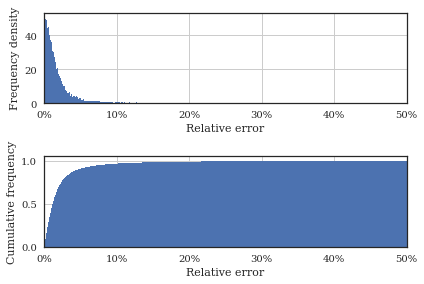

In [22]:
def draw_RE_hist(relative_error):
    
    fig, ax = plt.subplots(2,1)
#     fig.set_title('Absolute and relative error')

#     ax[0,0].hist(absolute_error, log=True, bins=200)
#     ax[0,0].set_xlabel('Absolute error')
#     ax[0,0].set_ylabel('Probability')
# #     ax[0,0].set_xlim(0, 1)
#     # ax.set_ylim(0, 0.03)
#     ax[0,0].grid(True)
    
#     ax[1,0].hist(absolute_error, bins=500, log=True,cumulative=True, density=True)
#     ax[1,0].set_xlabel('Relative error')
#     ax[1,0].set_ylabel('Probability')
#     ax[1,0].set_xlim(0, 0.5)
#     # ax.set_ylim(0, 0.03)
#     ax[1,0].grid(True)
    
    ax[0].hist(relative_error, bins=10000, density=True)
    ax[0].set_xlabel('Relative error')
    ax[0].set_ylabel('Frequency density')
    ax[0].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
    ax[0].set_xlim(0, 0.5)
    # ax.set_ylim(0, 0.03)
    ax[0].grid(True)
    
    
    ax[1].hist(relative_error, bins=10000, cumulative=True, density=True)
    ax[1].set_xlabel('Relative error')
    ax[1].set_ylabel('Cumulative frequency')
    ax[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
    ax[1].set_xlim(0, 0.5)
    # ax.set_ylim(0, 0.03)
    ax[1].grid(True)   
    
    plt.tight_layout()
    
    fig.savefig('test.pdf')

draw_RE_hist(relative_error)

